In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

import shap

from ucimlrepo import fetch_ucirepo 

from pathlib import Path

res_dir = Path.cwd() / "results"
  
# fetch dataset 
wine = fetch_ucirepo(id=109) 

# metadata 
print(wine.metadata) 
  
# variable information 
print(wine.variables) 
  
# data (as pandas dataframes) 
X = wine.data.features 
y = wine.data.targets 

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


{'uci_id': 109, 'name': 'Wine', 'repository_url': 'https://archive.ics.uci.edu/dataset/109/wine', 'data_url': 'https://archive.ics.uci.edu/static/public/109/data.csv', 'abstract': 'Using chemical analysis to determine the origin of wines', 'area': 'Physics and Chemistry', 'tasks': ['Classification'], 'characteristics': ['Tabular'], 'num_instances': 178, 'num_features': 13, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1992, 'last_updated': 'Mon Aug 28 2023', 'dataset_doi': '10.24432/C5PC7J', 'creators': ['Stefan Aeberhard', 'M. Forina'], 'intro_paper': {'title': 'Comparative analysis of statistical pattern recognition methods in high dimensional settings', 'authors': 'S. Aeberhard, D. Coomans, O. Vel', 'published_in': 'Pattern Recognition', 'year': 1994, 'url': 'https://www.semanticscholar.org/paper/83dc3e4030d7b9fbdbb4bde03ce12ab70ca10528', 'do

In [36]:
# standardize data: we keep only covariates since we are not interested in classification
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [5]:
# Fit KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)
print(kmeans.labels_)

[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 1 0 0 0 0 0 0 0 0 0 0 0 2
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 2 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


In [8]:
# Create a SHAP explainer
explainer = shap.KernelExplainer(kmeans.predict, X)

Using 178 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [9]:
# Choose a specific instance for explanation
instance_idx = 0
instance_to_explain = X[instance_idx]

In [10]:
# Generate SHAP values
shap_values = explainer.shap_values(instance_to_explain)

In [11]:
print(shap_values)

[0.25679266 0.00371177 0.02782587 0.0818318  0.14463572 0.06193769
 0.06900206 0.02251678 0.03173678 0.05767922 0.00861584 0.0675509
 0.18301684]


In [12]:
# Calculate explanation for all instances
shap_values = explainer.shap_values(X)

100%|██████████| 178/178 [02:55<00:00,  1.02it/s]


In [13]:
shap_values.shape

(178, 13)

In [14]:
# aggregate by cluster
shap_values_by_cluster = []
for cluster_idx in range(3):
    shap_values_by_cluster.append(shap_values[kmeans.labels_ == cluster_idx])

In [29]:
print(wine.variables.name.values) 


['class' 'Alcohol' 'Malicacid' 'Ash' 'Alcalinity_of_ash' 'Magnesium'
 'Total_phenols' 'Flavanoids' 'Nonflavanoid_phenols' 'Proanthocyanins'
 'Color_intensity' 'Hue' '0D280_0D315_of_diluted_wines' 'Proline']


In [22]:
X[kmeans.labels_ == 0].shape

(65, 13)

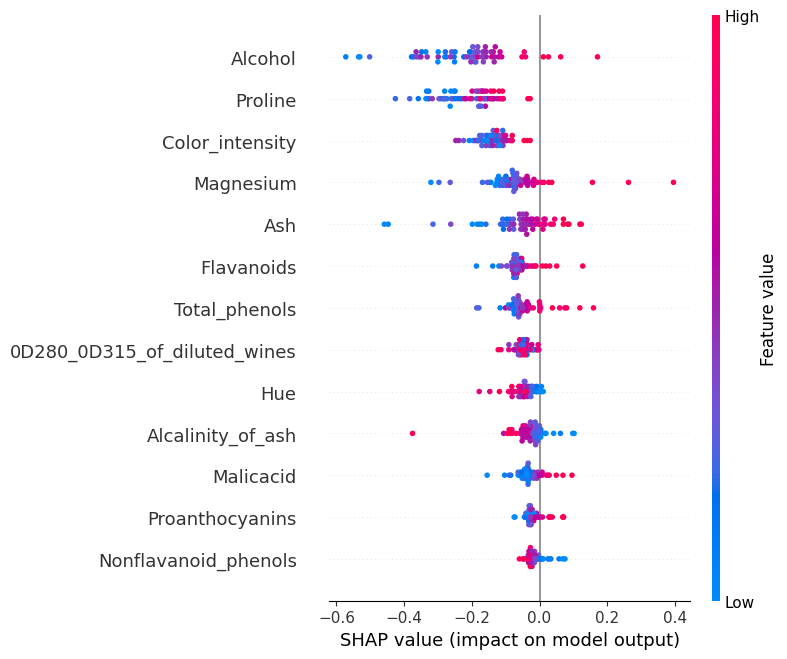

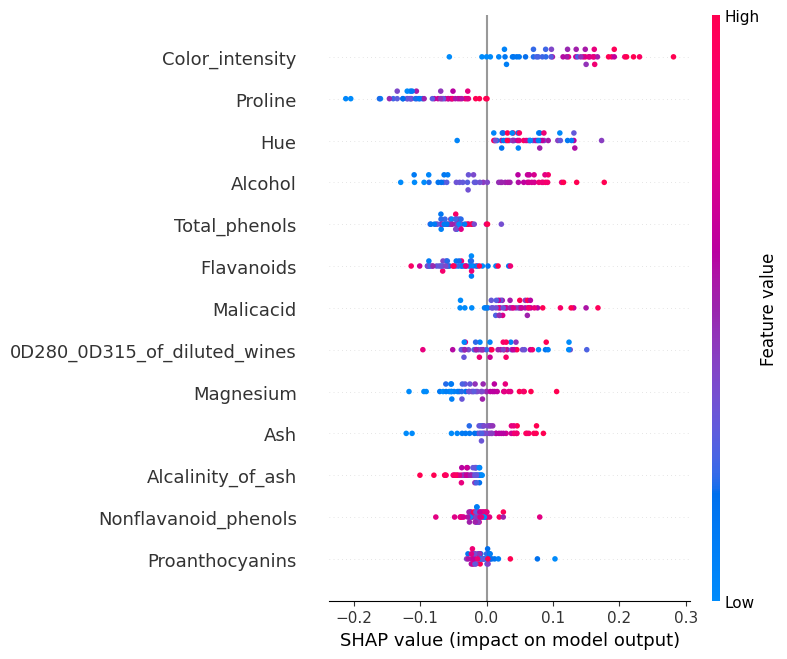

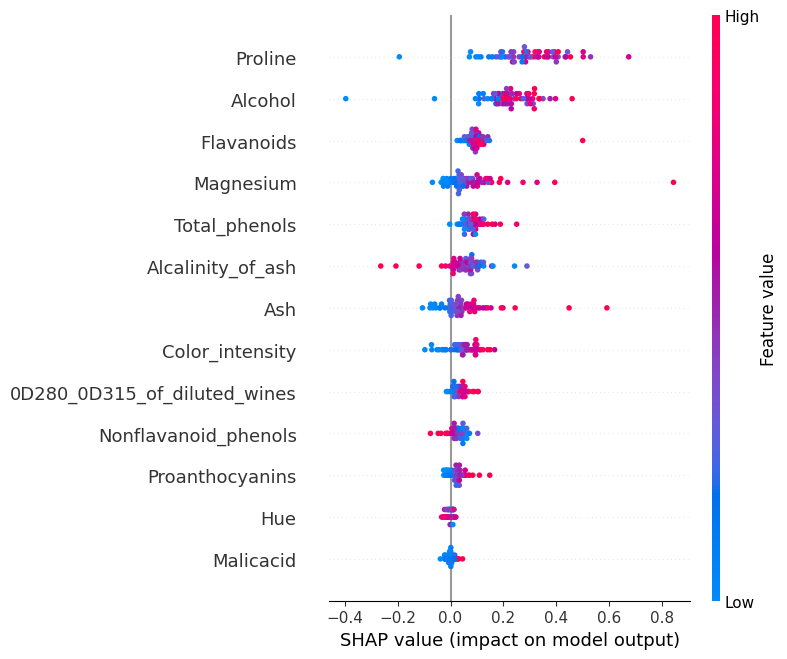

In [32]:
# plot mean over all instances in each cluster for each feature
shap.summary_plot(shap_values_by_cluster[0], X[kmeans.labels_ == 0], feature_names=wine.variables.name.values[1:])
shap.summary_plot(shap_values_by_cluster[1], X[kmeans.labels_ == 1], feature_names=wine.variables.name.values[1:])
shap.summary_plot(shap_values_by_cluster[2], X[kmeans.labels_ == 2], feature_names=wine.variables.name.values[1:])

Using 178 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 178/178 [03:32<00:00,  1.19s/it]


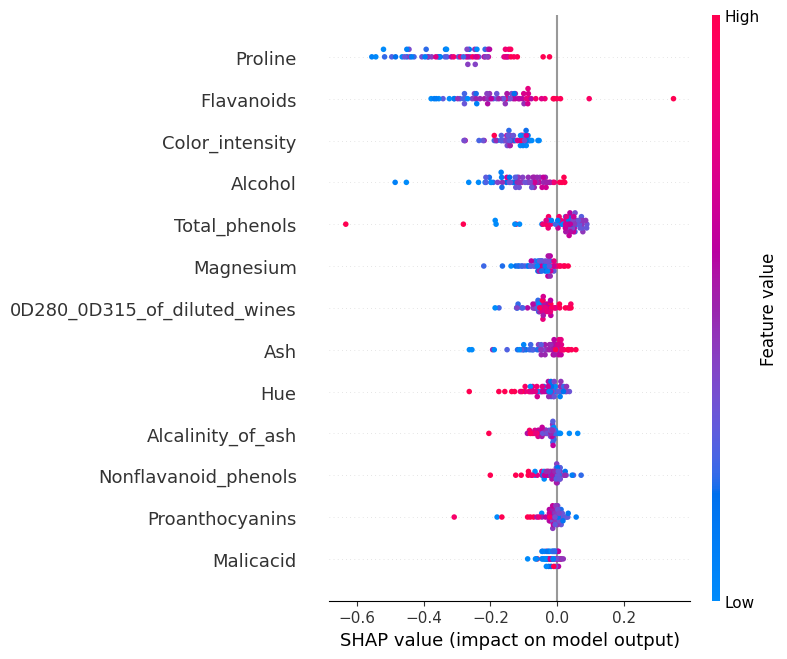

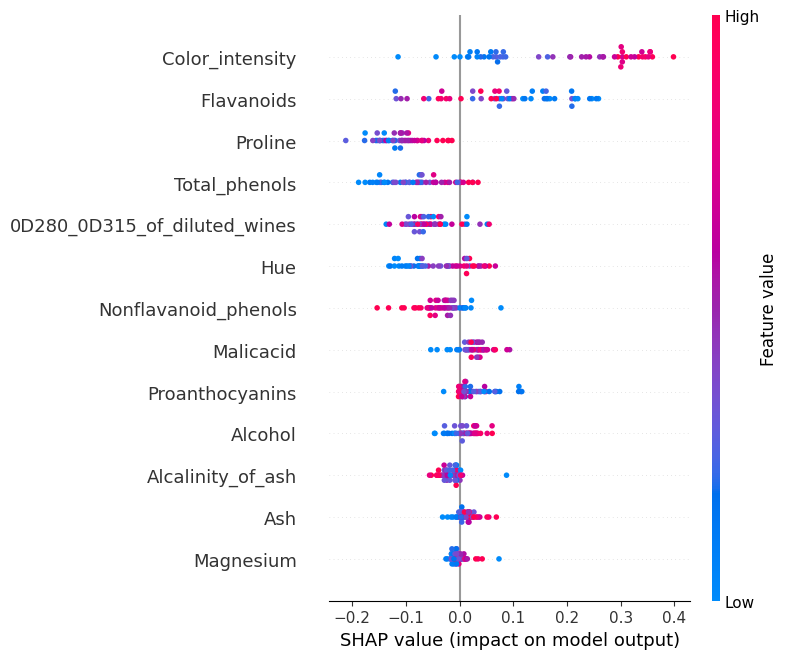

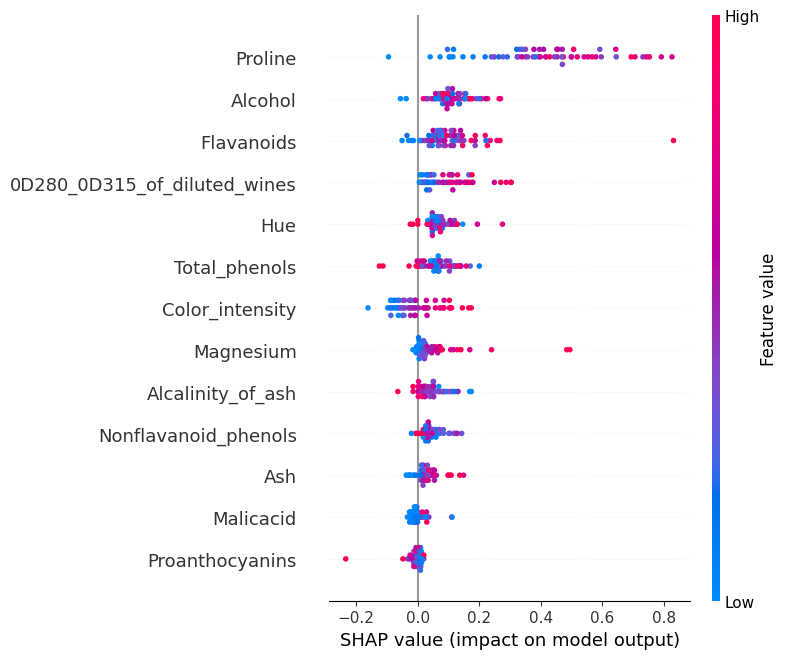

In [37]:
# Now we do the same with Gaussian Mixture Models
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, random_state=0).fit(X)

# Create a SHAP explainer
explainer = shap.KernelExplainer(gmm.predict, X)

# Calculate explanation for all instances

shap_values = explainer.shap_values(X)

# aggregate by cluster

shap_values_by_cluster = []

for cluster_idx in range(3):
    shap_values_by_cluster.append(shap_values[gmm.predict(X) == cluster_idx])

# plot mean over all instances in each cluster for each feature
shap.summary_plot(shap_values_by_cluster[0], X[gmm.predict(X) == 0], feature_names=wine.variables.name.values[1:])
shap.summary_plot(shap_values_by_cluster[1], X[gmm.predict(X) == 1], feature_names=wine.variables.name.values[1:])
shap.summary_plot(shap_values_by_cluster[2], X[gmm.predict(X) == 2], feature_names=wine.variables.name.values[1:])

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from ucimlrepo import fetch_ucirepo 

from ClusterInterpretability import ClusterInterpretability
  
# fetch dataset 
wine = fetch_ucirepo(id=109) 
  
# data (as pandas dataframes) 
X = wine.data.features 
y = wine.data.targets 

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# standardize data: we keep only covariates since we are not interested in classification
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [3]:
# Fit KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning


In [4]:
cluster_int = ClusterInterpretability(kmeans, X, wine.variables.name.values[1:], kmeans.n_clusters)

Using 178 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 178/178 [02:51<00:00,  1.04it/s]


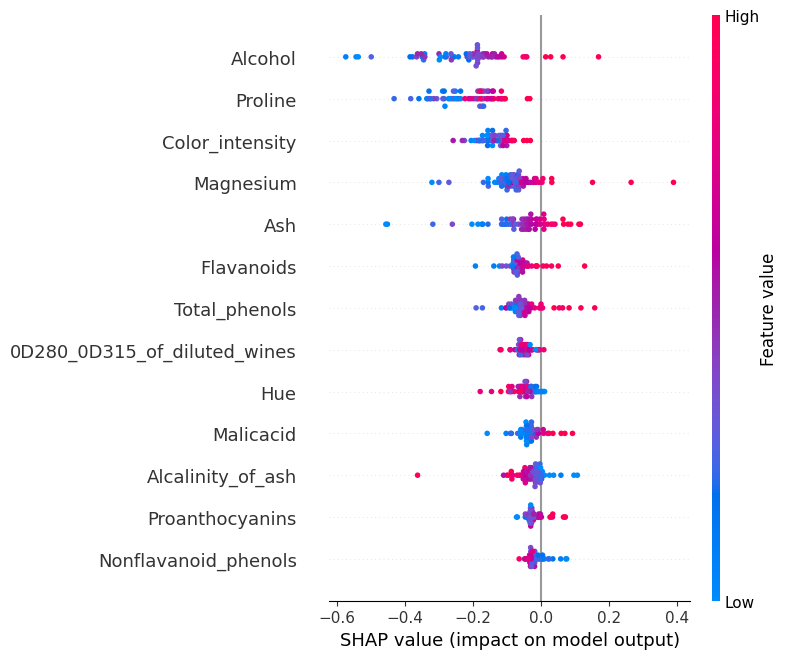

In [5]:
cluster_int.plot_explanations(0)